In [44]:
#-*- encoding: iso-8859-15 -*-
import numpy as np
from easydict import EasyDict as edict

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
from matplotlib import pyplot as plt

import heapq

# Import other python files


#### Configuration / parameters to set

In [2]:
def set_config(config_path = "config.txt", args = dict()):
    with open(config_path) as source:
        for line in source:
            line = line.strip()
            argLong, valueLong = line.split('=')
            arg = argLong.strip()
            value = valueLong.strip()
            if value == 'True':
                value = True
            elif value == 'False':
                value = False
            elif '.' in value:
                value = float(value)
            else:
                value = int(value)
            args[arg] = value
    return edict(args)

In [3]:
config_path = 'config.txt'
args = {}
args = set_config(config_path, args)
print(args)
#args.batch_size = 9

{'seq_len': 30, 'offset': 1, 'cuda': False, 'batch_size': 4, 'num_layers': 1, 'hidden_size': 64, 'lr': 0.1, 'clip': 1}


### Data Processing functions and classes

In [4]:
def prepare_text(textsource):
    text = ''
    with open(textsource, encoding="utf8") as txtsource:
        for line in txtsource:
            line = line.strip().lower()
            line = line.replace(',', '').replace('.', '')
            line = line.replace('»', '').replace('«', '')
            line = line.replace('"', '')
            line = line.replace(u'\ufeff', '')
            text += ' ' + line
    text = text[:32042] #### nachher wieder rauslöschen!!!
    return text
# Chevrons müssen noch weg

In [8]:
def prepare_data(text, seq_len, offset):
    # Get all the unique characters appearing in the text 
    chars = sorted(list(set(text)))
    char_idx = dict((c, i) for i, c in enumerate(chars))
    print('char_indices_map: ' + str(char_idx))
    print('len(char_indices_map): ' + str(len(char_idx)))
    idx_char = dict((i, c) for i, c in enumerate(chars)) #### das brauchen wir später!!!
    no_classes = len(chars) # the nr. of unique characters corresponds to the nr. of classes
    
    # count 'w' occurences, which is by far the least frequent with 1.6%
    wcount = 0
    for i in range(0, len(text) - seq_len, offset):
        if text[i + seq_len] == 'w':
            wcount += 1
    
    print('w-occurences: ' + str(wcount))
            
    # define counts and dict
    counts_dict = {' ': 0, '-': 1, '?': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h':10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'z': 27, 'ß': 28, 'ä': 29, 'ö': 30, 'ü': 31, '–': 32, '…': 33, '‹': 34, '›': 35}
    print('counts_dict: ' + str(counts_dict))
    counts = [0]*len(counts_dict)
    # Define training samples by splitting the text
    sentences = []
    next_chars = []
    for i in range(0, len(text) - seq_len, offset):
        if text[i + seq_len] == ' ':
            continue
        else:#if counts[counts_dict[text[i + seq_len]]] <= wcount:
            sentences.append(text[i: i + seq_len])
            next_chars.append(text[i + seq_len])
            #counts[counts_dict[text[i + seq_len]]] += 1

    #print('sentences', sentences)    
    #print('next_chars', next_chars)
    print('nr training samples', len(sentences))
    
    # Generate features and labels using one-hot encoding
    X = np.zeros((len(sentences), seq_len, len(chars)), dtype='f')
    y = np.zeros((len(sentences)))
    gt = np.zeros((len(sentences), len(chars)), dtype = 'f')
    
    for i, sentence in enumerate(sentences):
        for j, char in enumerate(sentence):
            X[i, j, char_idx[char]] = 1
        y[i] = char_idx[next_chars[i]]
        gt[i, char_idx[next_chars[i]]] = 1
        
    #print('next_chars: ' + str(next_chars[0]))
    #print('out: ' + str(X[0, :, :]))
    #print('target: ' + str(y[0]))
        
    return X, y, gt, char_idx, idx_char, no_classes

In [8]:
class TextDataset(Dataset):
    ''' A text dataset class which implements the abstract class torch.utils.data.Dataset. '''
    def __init__(self, text, seq_len, offset):
        self.data, self.target, self.gt, self.char_idx, self.idx_char, self.no_classes = prepare_data(text, seq_len, offset)
        
    def __getitem__(self, index):
        ''' Get the data for one training sample (by index) '''
        return self.data[index,:,:], self.target[index] 
    
    def __len__(self):
        ''' Get the number of training samples '''
        return self.data.shape[0]

### LSTM functions and classes

In [9]:
class LSTM_RNN(nn.Module):
    
    def __init__(self, no_classes):
        super(LSTM_RNN, self).__init__()
        
        self.lstm = nn.LSTM(input_size = no_classes, hidden_size = args.hidden_size, num_layers = args.num_layers)
        self.linear = nn.Linear(in_features = args.hidden_size, out_features = no_classes)
        self.softmax = nn.Softmax(dim=1)
        
        nn.init.normal( self.linear.weight, 0, 0.075)
        nn.init.normal(self.linear.bias, 0, 0.075)
        nn.init.xavier_normal(self.lstm.weight_hh_l0)
        nn.init.xavier_normal(self.lstm.weight_ih_l0)
        #nn.init.constant(self.lstm.bias, 0.0)

        
        # LSTM needs hidden variable which is initialized in self.init_hidden(self)
        self.hidden = self.init_hidden()
        
        # for m in self.modules():
        #     if isinstance(m, nn.Linear):
        #         m.weight.data.normal_(0, 0.075*0.075)
        #         m.bias.data.normal_(0, 0.075*0.075)
                
    
    def init_hidden(self):
        h0 = Variable(torch.zeros(args.num_layers, args.batch_size, args.hidden_size))
        c0 = Variable(torch.zeros(args.num_layers, args.batch_size, args.hidden_size))
        return (h0,c0)#Variable(torch.zeros((args.num_layers, args.batch_size, args.hidden_size)))
    
    def forward(self, x, hidden):
        #x = x.type(torch.DoubleTensor)
        #print(x)
        lstm_out, hidden = self.lstm(x, hidden) # (h0, c0 are set to default values)
        #print(lstm_out)
        #print("LSTM_OUT:")
        #print(lstm_out)
        #lstm_out = lstm_out.view(-1, lstm_out.size(2))
        #print("----------------")
        #print(lstm_out)
        linear_out = self.linear(lstm_out[-1])
        #print("Linear_OUT:")
        #print(linear_out)
        #res = self.softmax(linear_out) # use only the output of the last layer of lstm
        return linear_out, hidden

In [10]:
# Training loop (one epoch)
def train(model, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss() # use the cross-entropy loss
    total_loss = 0.0 # compute total loss over one epoch

    for batch_idx, (data, target) in enumerate(train_loader):
        #print(data)
        data = data.view(data.size(1), data.size(0), data.size(2))
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        
        hidden = model.init_hidden()
        optimizer.zero_grad()
        #print("data:")
        #print(data[0])
        output, hidden = model(data, hidden)
        #print("output:")
        #print(output[0])
        #print("target:")
        #print(target)
        loss = criterion(output, target.type(torch.LongTensor)) # check how far away the output is from the original data
        #print("loss:")
        #print(loss)
        loss.backward()#retain_graph=True)
        
        #torch.nn.utils.clip_grad_norm(model.parameters(), args.clip)
        optimizer.step()

        total_loss += loss.data[0]
        #print(total_loss)


    relative_loss = total_loss/float(len(train_loader))
    print('Mean loss over epoch %s: %s' %(epoch, relative_loss))#loss.data[0]))
    return relative_loss # return the relative loss for later analysis
            

In [11]:
# Prediction loop for ONE testdata tensor
def rnn_predict(model, testdata):
    ''' Note: testdata have to be submitted as a tensor'''
    testdata = torch.from_numpy(testdata)
    print("testdata:")
    print(testdata)
    model.eval()
    testdata = testdata.view(testdata.size(0), -1)
    if args.cuda:
        testdata = testdata.cuda()
    testdata = testdata.type(torch.FloatTensor)
    testdata = Variable(testdata)
    hidden = model.init_hidden()
    prediction = model(testdata, hidden)
    return prediction

### Other functions

In [12]:
''' Function that returns the largest factor of number that isn't the number itself '''
def lfactor(num):
    for i in range(num - 1, 0, -1): # go backwards from num - 1 to 1
        if num % i == 0:            # if a number divides evenly
            return i                # it's the largest factor

### Marvins test functions

In [13]:
# die funktion brauchen wir vllt gar nicht, je nachdem ob wir den test loader verwenden oder wie wir das auch immer machen
def prepare_input(text):
    X = np.zeros((args.seq_len, no_classes))  # array with one entry which have 20 lines, each 11 entrys
    for t, char in enumerate(text):
        X[t, char_idx[char]] = 1.
    return X

def sample(preds, top_n=1):
    print("test")
    preds = preds[-1].data.numpy()
    print(preds)
    print(preds.shape)
    #preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(len(preds), zip(preds, itertools.count()))


def predict_completion(model, text, topn=1):
    original_text = text
    generated = text
    completion = ''
    next_char = ''
    max_iterations = 1
    i = 0
    while next_char != ' ' and i < max_iterations:
        i += 1
        x = prepare_input(text)
        preds = rnn_predict(model, x)
        next_chars = sample(preds[0], top_n=topn)
        print('id, char: ' + str(next_chars[0][1]) + ', ' + str(idx_char[next_chars[0][1]]))
        text = text[1:] + idx_char[next_chars[0][1]]
        completion += idx_char[next_chars[0][1]]

    return completion


def predict_completions(model, text, n=3):
    x = prepare_input(text)
    preds = model.rnn_predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [idx_char[idx] + predict_completion(text[1:] + idx_char[idx]) for idx in next_indices]

### Main code

In [37]:
config_path = 'config.txt'
args = {}
args = set_config(config_path, args)
print(args)

# Generate train and test loader from our data
train_text = prepare_text('./Brown_Leseprobe.txt')
train_set = TextDataset(train_text, args.seq_len, args.offset)
#args.batch_size = lfactor(len(train_set))
train_loader = DataLoader(train_set, batch_size = args.batch_size, shuffle=False)
gt = train_set.gt

def dim(a):
    if not type(a) == list:
        return []
    return [len(a)] + dim(a[0])

# for i, val in enumerate(train_loader):
#     print(val)
#     if i==1:
#         break

test_text = prepare_text('./Brown_Leseprobe_test.txt')
test_set = TextDataset(test_text, args.seq_len, args.offset)
test_loader = DataLoader(test_set, batch_size = args.batch_size, shuffle=False)

# set further parameters
char_idx = train_set.char_idx
idx_char = train_set.idx_char
no_classes = train_set.no_classes
input_shape = (args.seq_len, no_classes) # seq_len * nr. of unique characters 

# get len of data to determine the possible batch_size
print(args.batch_size)


{'seq_len': 30, 'offset': 1, 'cuda': False, 'batch_size': 8, 'num_layers': 1, 'hidden_size': 128, 'lr': 0.1, 'clip': 1}
char_indices_map: {' ': 0, '!': 1, '*': 2, '-': 3, '1': 4, '3': 5, '7': 6, '8': 7, '9': 8, ':': 9, ';': 10, '?': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37, 'ß': 38, 'ä': 39, 'ó': 40, 'ö': 41, 'ü': 42, 'ā': 43, '–': 44, '‘': 45, '’': 46, '…': 47, '‹': 48, '›': 49}
len(char_indices_map): 50
w-occurences: 446
counts_dict: {' ': 0, '-': 1, '?': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'z': 27, 'ß': 28, 'ä': 29, 'ö': 30, 'ü': 31, '–': 32, '…': 33, '‹': 34, '›': 35}
nr training samples 27136


char_indices_map: {' ': 0, '!': 1, '*': 2, '-': 3, '1': 4, '3': 5, '7': 6, '8': 7, '9': 8, ':': 9, ';': 10, '?': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37, 'ß': 38, 'ä': 39, 'ó': 40, 'ö': 41, 'ü': 42, 'ā': 43, '–': 44, '‘': 45, '’': 46, '…': 47, '‹': 48, '›': 49}
len(char_indices_map): 50
w-occurences: 446
counts_dict: {' ': 0, '-': 1, '?': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'z': 27, 'ß': 28, 'ä': 29, 'ö': 30, 'ü': 31, '–': 32, '…': 33, '‹': 34, '›': 35}


nr training samples 27136


8


In [40]:
# Generate model
print(input_shape)
rnn = LSTM_RNN(no_classes)
if args.cuda:
    rnn.cuda()
print(rnn)

(30, 50)
LSTM_RNN(
  (lstm): LSTM(50, 128)
  (linear): Linear(in_features=128, out_features=50)
  (softmax): Softmax()
)


In [41]:
# Initialize the optimization algorithm
optimizer = optim.Adam(rnn.parameters(), lr=0.005)

In [42]:

# Run training and store history
history = dict()
history['loss_train'] = []
history['loss_test'] = []

# wie wir die accuracy machen, weiß ich noch nicht...
#history['acc_train'] = []
#history['acc_test'] = []
print(args.batch_size)
for epoch in range(100):
    loss_train = train(rnn, epoch)        
    history['loss_train'].append(loss_train)      

8


Mean loss over epoch 0: 2.2567041990927086


Mean loss over epoch 1: 2.1232144277683407


Mean loss over epoch 2: 2.081141548055523


Mean loss over epoch 3: 2.0249211948610983


Mean loss over epoch 4: 1.9626781576717238


Mean loss over epoch 5: 1.9256090896537985


Mean loss over epoch 6: 1.910148560280367


Mean loss over epoch 7: 1.8813079361856546


Mean loss over epoch 8: 1.8728767751698505


Mean loss over epoch 9: 1.851432406519241


Mean loss over epoch 10: 1.8446650492853292


Mean loss over epoch 11: 1.8298673171479747


Mean loss over epoch 12: 1.8188602111987628


Mean loss over epoch 13: 1.8058642133156646


Mean loss over epoch 14: 1.7883281370203168


KeyboardInterrupt: 

C:\WinPython\miniconda2\lib\site-packages\torch\serialization.py:158: UserWarning: Couldn't retrieve source code for container of type LSTM_RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


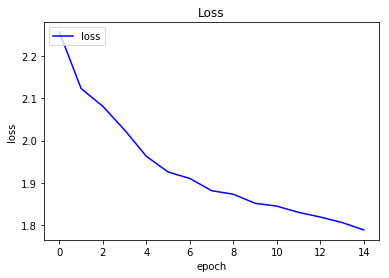

In [ ]:
torch.save(rnn, 'rnn_bsize8-l1.8.pt')

def plotLineData(header, yLabel, firstData, firstLabel, firstColor='b', xLabel='epoch'):
    plt.plot(firstData, color=firstColor)
    plt.title(header)
    plt.ylabel(yLabel)
    plt.xlabel(xLabel)
    plt.legend([firstLabel], loc='upper left')
    plt.savefig("rnn_bsize8-l1.8.png")
    plt.show()
plotLineData("Loss", "loss", history['loss_train'], "loss")
# Try a prediction

#testdata = Variable(torch.from_numpy(test_set.data[0])) # get first element from the test set
#truth = test_set.target[0]
#print(testdata,truth)

#prediction = rnn(testdata)
## dann muss man hier noch auf die sizes achten, ach verdammt
#prepare_input("This is an example of input for our LSTM".lower(), train_set.data, char_idx)
#print(predict_completions(seq, 5))

In [493]:

testcases = ["zahnr", " währ", "mühsa", "winde", "erreg", "steil", "krall", "aufra", "spitz"]
for case in testcases:
    predict_completion(rnn, case.lower(), topn=3)

testdata:


Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     1     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0

test
[-8.04064751  2.67749977 -6.63644934  3.28877997 -2.14485502  2.06122684
  1.80935168 -4.66574812  1.05909824  2.55170774 -6.96058178 -3.50340962
  3.721138   -6.09183693  1.15532458 -3.69657302 -1.50856829  2.23330736
  4.27194929 -3.12490702  0.12552544 -9.28370094 -1.86604738 -5.33894253
 -5.39690399 -6.35762501 -3.18529677 -8.7940836   0.42415631 -8.59319305]
(30,)
id, char: 18, s
testdata:


Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     1     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0   


(30,)
id, char: 5, e
testdata:


Columns 0 to 12 
    0     0     0     0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     1     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0  

test
[ -8.02255821   3.52648258  -3.25683308   3.53440857  -0.71668553
   7.40387964  -4.13997793 -10.8001194    1.55285907  -0.17420679
  -3.63638043  -7.54215717  -8.90991974  -2.15987539   6.08065653
   0.32635218   3.08507133   3.70598793  -0.43737108  -2.57467604
   0.72847307  -9.15349102   3.31164837  -5.24285507  -1.42512083
  -7.32838488  -6.20543242  -7.06478977  -6.7322011   -6.38717461]
(30,)
id, char: 5, e
testdata:


Columns 0 to 12 
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     1     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
  

test
[-6.19163609 -2.27756882 -8.19443417 -3.17603588 -1.90317488  7.27658224
  2.71001506 -5.67663574  0.76343232  2.22419667 -5.59305763 -3.79128385
  8.85343933  0.90763885 -0.40419811  0.44203103  2.18676639 -3.12045956
  1.94815302  0.41431487 -2.4201777  -2.53792262 -4.18731213 -6.02349091
 -4.31631899 -4.62060642  0.07088119 -2.82968807 -2.31954455 -6.91437626]
(30,)
id, char: 12, l


In [ ]:
print(train_set.no_classes)
print(char_idx)
print(args.batch_size)


29
{'ö': 26, 'c': 3, 'd': 4, 'j': 10, 'g': 7, 'p': 16, 'l': 12, 'e': 5, 'r': 17, 'b': 2, 't': 19, 'f': 6, 'ü': 27, ' ': 0, 'u': 20, 'z': 23, 'v': 21, 'k': 11, 'w': 22, 'ß': 24, 'o': 15, 'n': 14, 'ä': 25, 'i': 9, 'h': 8, 's': 18, '–': 28, 'm': 13, 'a': 1}
81
